In [61]:
!pip install datasets scikit-learn joblib scipy


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack


In [64]:
print("Cargando Java/C# (code_to_code_trans)...")
ds_java_cs = load_dataset("google/code_x_glue_cc_code_to_code_trans", "default")

print("Cargando C (BigVul)...")
ds_c = load_dataset("bstee615/bigvul")

print("Cargando Python (code_completion_line)...")
ds_py = load_dataset("google/code_x_glue_cc_code_completion_line", "python")

print("Cargando JavaScript (code_to_text)...")
ds_js = load_dataset("google/code_x_glue_ct_code_to_text", "javascript")


Cargando Java/C# (code_to_code_trans)...
Cargando C (BigVul)...
Cargando Python (code_completion_line)...
Cargando JavaScript (code_to_text)...


Generating test split: 100%|██████████| 3291/3291 [00:00<00:00, 96206.74 examples/s]


In [65]:
codes = []
langs = []

# Java + C#
train_java_cs = ds_java_cs["train"]

for item in train_java_cs.select(range(min(2000, len(train_java_cs)))):
    java_code = item["java"]
    cs_code = item["cs"]

    if java_code:
        codes.append(java_code)
        langs.append("java")

    if cs_code:
        codes.append(cs_code)
        langs.append("csharp")

# C (BigVul) - campo "func"
train_c = ds_c["train"]
for item in train_c.select(range(min(2000, len(train_c)))):
    code_c = item.get("func")
    if code_c:
        codes.append(code_c)
        langs.append("c")

# Python - campo "code"
train_py = ds_py["train"]
for item in train_py.select(range(min(2000, len(train_py)))):
    code_py = item.get("code")
    if code_py:
        codes.append(code_py)
        langs.append("python")

# JavaScript - campo "code"
train_js = ds_js["train"]
for item in train_js.select(range(min(2000, len(train_js)))):
    code_js = item.get("code")
    if code_js:
        codes.append(code_js)
        langs.append("javascript")

len(codes), len(langs)


(6000, 6000)

In [66]:
dangerous_map = {
    "java": [
        "Runtime.getRuntime", "exec(", "Statement", "createStatement",
        "executeQuery", "executeUpdate"
    ],
    "csharp": [
        "Process.Start", "SqlCommand", "ExecuteReader", "ExecuteNonQuery",
        "Eval(", "File.ReadAllText"
    ],
    "c": [
        "strcpy", "strncpy(", "gets(", "scanf(", "sprintf(", "malloc(", "free(",
    ],
    "python": [
        "eval(", "exec(", "os.system", "subprocess.Popen", "subprocess.call",
        "pickle.loads", "yaml.load("
    ],
    "javascript": [
        "eval(", "innerHTML", "document.write", "Function(", "setTimeout(",
    ],
}

sanitizers_map = {
    "java": ["PreparedStatement", "setString(", "setInt("],
    "csharp": ["SqlParameter", "AddWithValue"],
    "c": ["snprintf", "strncpy_s"],
    "python": ["shlex.quote", "escape", "html.escape"],
    "javascript": ["encodeURI", "encodeURIComponent", "DOMPurify.sanitize"],
}

def estimate_complexity(code: str) -> int:
    # complejidad muy aproximada
    return sum(
        code.count(kw)
        for kw in ["if ", "for ", "while ", "switch", "case ", "try", "catch", "elif ", "else:"]
    )

def extract_features(code: str, lang: str) -> dict:
    feats = {}

    # tamaño / tokens
    feats["length_chars"] = len(code)
    feats["num_lines"] = code.count("\n") + 1
    feats["num_tokens"] = len(re.findall(r"\w+", code))

    # “complejidad” aproximada tipo AST
    feats["complexity_score"] = estimate_complexity(code)

    # funciones peligrosas por lenguaje
    for d in dangerous_map.get(lang, []):
        feats[f"{lang}_danger_{d}"] = code.count(d)

    # sanitizadores / escapes
    for s in sanitizers_map.get(lang, []):
        feats[f"{lang}_sanitize_{s}"] = code.count(s)

    # one-hot del lenguaje
    feats[f"lang_{lang}"] = 1

    return feats


In [67]:
def assign_label(code: str, lang: str) -> int:
    for d in dangerous_map.get(lang, []):
        if d in code:
            return 1
    return 0


In [68]:
rows = []

for code, lang in zip(codes, langs):
    feats = extract_features(code, lang)
    feats["label"] = assign_label(code, lang)
    rows.append(feats)

df = pd.DataFrame(rows).fillna(0)
df.head(), df["label"].value_counts(), df.shape


(   length_chars  num_lines  num_tokens  complexity_score  \
 0           196          2          11                 0   
 1           380          2          23                 0   
 2           172          2          11                 0   
 3           344          2          23                 0   
 4            90          2           6                 0   
 
    java_danger_Runtime.getRuntime  java_danger_exec(  java_danger_Statement  \
 0                             0.0                0.0                    0.0   
 1                             0.0                0.0                    0.0   
 2                             0.0                0.0                    0.0   
 3                             0.0                0.0                    0.0   
 4                             0.0                0.0                    0.0   
 
    java_danger_createStatement  java_danger_executeQuery  \
 0                          0.0                       0.0   
 1                          

In [69]:
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 3),
    token_pattern=r"[A-Za-z_]\w+"
)

X_tfidf = tfidf.fit_transform(codes)
X_tfidf.shape


(6000, 20000)

In [70]:
X_manual = df.drop(columns=["label"]).values
y = df["label"].values

X = hstack([X_tfidf, X_manual])
X.shape, y.shape


((6000, 20032), (6000,))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = RandomForestClassifier(
    n_estimators=900,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))


Accuracy: 0.9833333333333333
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1174
           1       0.75      0.35      0.47        26

    accuracy                           0.98      1200
   macro avg       0.87      0.67      0.73      1200
weighted avg       0.98      0.98      0.98      1200



In [72]:
joblib.dump(model, "model.joblib")
joblib.dump(tfidf, "vectorizer.joblib")
print("Modelo y vectorizador guardados ✔")


Modelo y vectorizador guardados ✔


In [74]:
!pip install seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 435.7 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/294.9 kB 648.1 kB/s eta 0:00:01
   -------------------- ------------------- 153.6/294.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


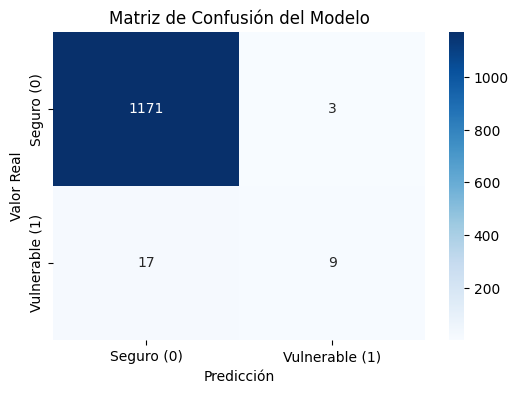

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# generar matriz
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Seguro (0)", "Vulnerable (1)"],
            yticklabels=["Seguro (0)", "Vulnerable (1)"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión del Modelo")
plt.show()
